# Page rank

## Network classes

In [1]:
class Network:   
    def __init__(self):
        self.pages = []
        self.counter = 0
    
    def __iter__(self):
        return iter(self.pages)
    
    def addPage(self, page):
        page.id = self.counter
        self.counter += 1
        self.pages.append(page)
        
    def addPages(self, *args):
        for page in args:
            self.addPage(page)
        
    def getPages(self):
        return self.pages
    
    def size(self):
        return len(self.pages)
    
    def showRanking(self):
        for page in self:
            print(f'{page.name}: {page.rank}')

In [2]:
class Page:
    def __init__(self, name):
        self.name = name
        self.links = []
        
    def __repr__(self):
        return self.name
    
    def __str__(self):
        return self.name
    
    def addLinkTo(self, other):
        self.links.append(other)
        
    def outDegree(self):
        return len(self.links)

### Example

In [3]:
wiki = Page("Wikipedia")
yt = Page("YouTube")
twitter = Page("Twitter")
wiki.addLinkTo(yt)
wiki.addLinkTo(twitter)
yt.addLinkTo(twitter)
twitter.addLinkTo(yt)

In [4]:
internet = Network()
internet.addPages(yt, wiki, twitter)

In [5]:
pages = internet.getPages()
pages

[YouTube, Wikipedia, Twitter]

In [6]:
pages[1].links

[YouTube, Twitter]

In [7]:
with open("california.txt") as f:
    content = f.read().splitlines()

In [8]:
california = Network()
for line in content:
    if line[0] == 'n':
        california.addPage(Page(line.split()[2]))
    elif line[0] == 'e':
        n1 = california.pages[int(line.split()[1])]
        n2 = california.pages[int(line.split()[2])]
        
        n1.addLinkTo(n2)

## Ranking the pages

In [9]:
class PageRanker:
    @staticmethod
    def rank(network, steps, alpha):
        PageRanker.calculateInitialRanking(network)
        PageRanker.calculateJumpingProbabilities(network)
        
        newRanks = {}
        for _ in range(0, steps):
            for page in network:
                newRanks[page] = 0
                for other in page.links:
                    newRanks[page] += other.rank / page.outDegree()
                newRanks[page] *= alpha
                newRanks[page] += (1-alpha) * page.q
                
        for page in network:
            page.rank = newRanks[page]
    
    @staticmethod
    def calculateInitialRanking(network):
        for page in network:
            page.rank = 1 / network.size()
            
    @staticmethod
    def calculateJumpingProbabilities(network):
        for page in network:
            page.q = 1 / network.size()

### Example

In [10]:
PageRanker.rank(internet, 1000, 0.5)

In [11]:
internet.showRanking()

YouTube: 0.3333333333333333
Wikipedia: 0.3333333333333333
Twitter: 0.3333333333333333


In [12]:
PageRanker.rank(california, 100, 0.5)

## Visualization of (small) networks

### With networkx

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

In [14]:
G = nx.DiGraph()
for page in internet:
    G.add_node(page)
    for other in page.links:
        G.add_edge(page, other)

In [15]:
pos = nx.layout.spring_layout(G)

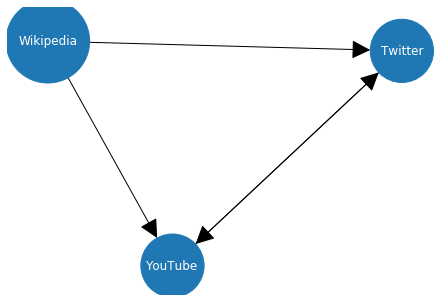

In [16]:
node_sizes = [1000 + 3000*len(page.links) for page in G.nodes()]
nx.draw(G, pos, with_labels = True, node_size=node_sizes, arrowsize=40, font_color="white")
plt.show()

### With graphviz

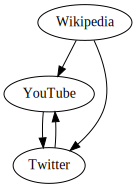

In [17]:
from graphviz import Digraph

f = Digraph()
for page in internet:
    f.node(str(page))
    for other in page.links:
        f.edge(str(page), str(other))
        
f